## Calibrating the parameters of a low contrast penetration measurement ImageJ JavaScript

The low_contast_penetration.js JavaScript code works by assessing whether the mean grey value of a row of 20 pixels is less than a specified threshold. This threshold is determined as a proportion of the grey values of the pixels near 0mm depth. In order to obtain this proportion, I analysed images which a Clinical Scientist had classified and attempted to identify what the mean threshold was. Firstly, I recorded the following data obtained from these images in a spreadsheet. 

In [1]:
import pandas as pd

df = pd.read_csv('baseline_measurements.csv')
df[['image_no_marked','probe_type','called_depth_mm','mean_contrast_20px_at zero',
    'mean_contrast_20px_at_called_depth','proportion']]

,image_no_marked,probe_type,called_depth_mm,mean_contrast_20px_at zero,mean_contrast_20px_at_called_depth,proportion
0,US000005,CURVED LINEAR,126.6,49.4,39.1,0.791498
1,US000007,CURVED LINEAR,132.8,43.9,35.1,0.799544
2,US000009,CURVED LINEAR,134.9,38.4,32.8,0.854167
3,US000028,LINEAR,47.2,42.7,31.4,0.735363
4,US000029,LINEAR,46.9,42.7,35.7,0.836066
5,US000032,LINEAR,47.2,41.4,35.0,0.845411
6,US000034,LINEAR,46.6,40.2,31.8,0.791045
7,US000005,CURVED LINEAR,84.1,65.3,51.7,0.791730
8,US000015,CURVED LINEAR,131.3,50.2,37.7,0.750996


I then obtained summary statistics of proportion of that rows grey value at called depth as a crude measure and plotted this.

In [2]:
from math import sqrt

proportion_mean = df['proportion'].mean()
proportion_std = df['proportion'].std()

print("Mean of proportions = " + str(proportion_mean))
print("Standard Deviations of proportions = " + str(proportion_std))

xs = list(df.index)
ys = list(df.proportion)
y_errs = [sqrt((i * (1 - i))) for i in ys]

err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, y_errs):
    err_xs.append((x, x))
    err_ys.append((y - yerr/2, y + yerr/2))

Mean of proportions = 0.799535503222
Standard Deviations of proportions = 0.0404588406347


In [3]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, show
from bokeh.models import Range1d
output_notebook()

fig = figure(title='Threshold determined by Clinical Scientist',
            x_axis_label='Image Number',
            y_axis_label='Proportion of "zero" grey value')
fig.circle(xs,ys,radius=0.1)
fig.set(y_range=Range1d(0, 1))
fig.multi_line(xs=[[0,8],[0,8],[0,8]],
               ys=[[proportion_mean,proportion_mean],
                   [proportion_mean+proportion_std,proportion_mean+proportion_std],
                   [proportion_mean-proportion_std,proportion_mean-proportion_std]],
               color=['blue','grey','grey'],
               line_width=1)
show(fig);

BokehJS successfully loaded.

I then then implemented an algorithm which started at 0 mm and looked for a row of pixels in the 20 mm wide ROI which had a grey value less than 0.8 of the grey value 0 mm. I used 0.8 as this seemed a sensible measure given the data obtained from the baseline measurements.

This algorithm was calling at depths much to shallow so I coded in a number of other parameters. Parameters were:

* Threshold proportion
* Number of rows below threshold before call is made
* Number of rows to backtrack once sufficient number of rows below threshold are observed
* Minimum number of pixels from 'zero' point before call can be made

After several iterations of algorithm re-design it was clear that differences in parameter values for different types of probe (as can be seen from table below). For each parameter, there are two possible values - one for linear and one for curved linear probes. 

In [4]:
alg_df = pd.read_csv('algorithm1.csv')
alg_df

,image_no,disc,probe_type,actual,algorithm1,algorithm2,algorithm3,algorithm4,algorithm5,algorithm6,algorithm7
0,US000004,1,CURVED_LINEAR,126.6,130.3,130.3,129.0,133.2,129.0,130.7,131.1
1,US000006,1,CURVED_LINEAR,132.8,129.4,128.2,125.7,129.8,125.7,130.3,128.6
2,US000008,1,CURVED_LINEAR,134.9,139.0,139.0,136.5,140.7,136.5,139.4,139.0
3,US000027,1,LINEAR,47.2,44.2,43.6,0.0,0.0,0.0,47.1,47.1
4,US000030,1,LINEAR,46.9,44.1,42.2,0.0,0.0,0.0,44.8,44.8
5,US000031,1,LINEAR,47.2,45.0,44.5,0.0,0.0,0.0,47.7,47.7
6,US000033,1,LINEAR,46.6,44.4,43.9,0.0,0.0,0.0,47.1,47.1
7,US000004,3,CURVED_LINEAR,84.1,0.0,0.0,0.0,0.0,0.0,75.4,73.7
8,US000016,3,CURVED_LINEAR,131.3,128.4,127.6,126.9,130.6,126.9,130.6,131.0


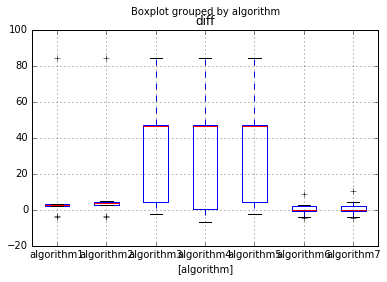

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

diff_df = pd.DataFrame(columns=['algorithm','diff'])
count_int = 0;
for i in range(1,8):
    alg_name = 'algorithm' + str(i)
    diff = alg_df['actual'] - alg_df[alg_name]
    for j in range(0,9):
        diff_df.loc[count_int] = [alg_name,diff[j]]
        count_int = count_int + 1
diff_df.boxplot(by='algorithm')
plt.show()

Obtaining summary statistics of the classification error of each algorithm.

In [6]:
from scipy.stats import ttest_rel
alg_df_summary = pd.DataFrame(columns=['p_val','mean','std','se']);
for i in range(1,8):
    alg_name = 'algorithm' + str(i)
    diff = alg_df['actual'] - alg_df[alg_name]
    alg_df_summary.loc[i] = [ttest_rel(alg_df['actual'],alg_df[alg_name])[1],diff.mean(),diff.std(),(diff.std()/sqrt(6))]
alg_df_summary

,p_val,mean,std,se
1,0.298520,10.311111,27.822942,11.358669
2,0.269930,10.922222,27.645378,11.286178
3,0.015010,31.055556,30.202902,12.330283
4,0.025944,29.255556,32.177947,13.136592
5,0.015010,31.055556,30.202902,12.330283
6,0.711084,0.500000,3.907685,1.595306
7,0.593280,0.833333,4.494719,1.834961


Considering the p-values obtained from paired t-tests of the differences between actual and estimated depth, it seems algorithms 1,2,6 and 7 all have p-values > 0.05 and are therefore plausible candidates. 

In [7]:
xs = list(alg_df_summary.index)
ys = list(alg_df_summary['mean'])
y_errs = list(alg_df_summary['se'])

err_xs = []
err_ys = []

for x, y, yerr in zip(xs, ys, y_errs):
    err_xs.append((x, x))
    err_ys.append((y - (yerr)/2, y + (yerr)/2))

fig2 = figure(title = 'Algorithm Performance', y_axis_label = 'Mean difference from actaul +/- SE', x_axis_label = 'Algorithm')
fig2.circle(xs,ys,radius=0.05)
fig2.multi_line(err_xs, err_ys, line_width=5)
fig2.set(y_range=Range1d(-10,40))
show(fig2);

Algorithms 6 and 7 clearly appear to have the samllest variation of differences between actual and estimated values and these differences are grouped around 0 (i.e. no difference). 

I attempted to classify some unseen images using both algorithm 6 and found that this algorithm did not scale to other images well and generally failed to make a call on the majority of images. 

Algorithm 7 is effectively Algorithm 6 but tweeked so that it does make calls on unseen images - some of the parameters have been 'relaxed' albeit without losing too much performance as can be see from the above plot. 